In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Masking, TimeDistributed
from sklearn.metrics import mean_absolute_error
from scipy.interpolate import UnivariateSpline
import keras

In [3]:
sensor_files = ['202501_AirVisual_values.csv']

all_data = []

for file in sensor_files:
    # Replace 'Date' with the actual column name in your CSV that represents datetime
    df = pd.read_csv(
        file,
        parse_dates=['Date'],
        index_col='Date',
        infer_datetime_format=True
    )
    
    df.fillna(-1, inplace=True)
    
    arr = df[["PM2_5(ug/m3)", "PM10(ug/m3)", "PM1(ug/m3)", "Temperature(C)", "Humidity(%RH)", "CO2(ppm)"]].values
    
    all_data.append(arr)

data_array = np.concatenate(all_data, axis=0)  
print("Final data shape:", data_array.shape)

C:\Users\Nhat Minh\AppData\Local\Temp\ipykernel_15396\1614895082.py:7: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
C:\Users\Nhat Minh\AppData\Local\Temp\ipykernel_15396\1614895082.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(


Final data shape: (267844, 6)


In [47]:
sensor_files = ['202501_AirVisual_values.csv']
all_data = []

for file in sensor_files:
    # Read CSV with the 'Date' column parsed as datetime and set as the index
    df = pd.read_csv(
        file,
        parse_dates=['Date'],
        index_col='Date',
        infer_datetime_format=True
    )
    
    # Fill missing values
    df.fillna(-1, inplace=True)
    # Resample the DataFrame to 20 seconds intervals using the mean aggregation
    df_1min = df.resample('30S').mean()
    
    # Save the resampled DataFrame to a new CSV file.
    # The new filename is based on the original filename.
    output_file = '202501_AirVisual_values(20sec).csv'
    df_1min.to_csv(output_file)
    print(f"Resampled data saved to {output_file}")
    
    # Extract only the selected columns for further processing (if needed)
    cols = ["PM2_5(ug/m3)", "PM10(ug/m3)", "PM1(ug/m3)",
            "Temperature(C)", "Humidity(%RH)", "CO2(ppm)"]
    arr = df_1min[cols].values
    all_data.append(arr)

# Concatenate all arrays along the time axis if you have multiple files.
data_array = np.concatenate(all_data, axis=0)
print("Final data shape:", data_array.shape)


C:\Users\Nhat Minh\AppData\Local\Temp\ipykernel_15544\4090843417.py:6: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
C:\Users\Nhat Minh\AppData\Local\Temp\ipykernel_15544\4090843417.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(


Resampled data saved to 202501_AirVisual_values(20sec).csv
Final data shape: (2880, 6)


In [4]:
def data_normalize_2d(data_2d):
    # data_2d shape: [time, features]
    # Trả về cùng shape, đã log-transform, -1 giữ nguyên
    new_data = data_2d.copy()
    rows, cols = new_data.shape
    for i in range(rows):
        for j in range(cols):
            val = new_data[i, j]
            if val == -1:
                # Giữ nguyên nếu -1 (dữ liệu thiếu)
                continue
            else:
                # Tránh log(0)
                new_data[i, j] = np.log(val) if val != 0 else 1e-5
    return new_data

In [5]:
def split_train_test(data_2d, start, end):
    length = data_2d.shape[0]
    s = int(length * start)
    e = int(length * end)
    
    # Lấy train = 0->s và e->cuối (như code cũ),
    # test = s->e
    train_data = np.concatenate((data_2d[:s], data_2d[e:]), axis=0)
    test_data = data_2d[s:e]
    return train_data, test_data


In [6]:
def data_split_multivar(data_2d, train_time, test_time, predict_position, stride):
    # data_2d: shape [time, features]
    # train_time: số bước thời gian cho input
    # test_time: số bước thời gian cho output
    # predict_position: khoảng trễ giữa train và test
    # stride: bước nhảy của cửa sổ
    # Mình kì vọng nó sẽ return: x, y = [samples, train_time, features], [samples, test_time, features]
    x, y = [], []
    period = train_time + predict_position + test_time
    i = 0
    while i + period <= data_2d.shape[0]:
        # Input window
        x_temp = data_2d[i : i + train_time, :]
        # Output window (multi-step)
        y_temp = data_2d[
            i + train_time + predict_position :
            i + train_time + predict_position + test_time, :
        ]
        x.append(x_temp)
        y.append(y_temp)
        i += stride
    return np.array(x), np.array(y)



In [7]:
def stacked_LSTM(X, Y):

    time_step = X.shape[1]   # train_time
    input_dim = X.shape[2]   # số feature đầu vào
    out = Y.shape[2]         # số feature đầu ra
    # test_time = Y.shape[1]  # Số bước dự báo => ta không cần gán, 
                             # nhưng để ý Y có shape [samples, test_time, out]
    
    model = Sequential()
    model.add(Masking(mask_value=-1., input_shape=(time_step, input_dim)))
    # LSTM trả về chuỗi => shape [batch, train_time, hidden_dim]
    model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True)))
    
    # Mỗi bước time_step => Dense(out)
    model.add(TimeDistributed(Dense(out)))
    
    model.compile(
        loss='mean_absolute_error',
        optimizer=keras.optimizers.Adam(learning_rate=1e-5)
    )
    
    hist = model.fit(
        X, Y,
        epochs=50,
        validation_split=0.2,
        verbose=1,
        batch_size=10
    )
    model.summary()
    return model, hist


In [8]:
def SP_Learner(data_array, train_time, test_time, predict_position, stride, start, end):
    data_norm = data_normalize_2d(data_array)
    
    train_data, test_data = split_train_test(data_norm, start, end)
    
    train_x, train_y = data_split_multivar(train_data, train_time, test_time, predict_position, stride)
    test_x, test_y = data_split_multivar(test_data, train_time, test_time, predict_position, stride)
    
    model, hist = stacked_LSTM(train_x, train_y)
    
    pred_y = model.predict(test_x)
    
    mae_value = mean_absolute_error(test_y.reshape(-1), pred_y.reshape(-1))
    error = test_y.reshape(-1) - pred_y.reshape(-1)
    std_error = np.std(error)
    
    print("Test MAE:", mae_value)
    print("Standard Deviation of error:", std_error)
    
    return pred_y, test_y, model

In [9]:
# Điều chỉnh các tham số cho multi-step:
# Ví dụ: train_time=12, test_time=12 => 12 bước đầu vào, 12 bước đầu ra
# predict_position=8 => chờ 8 bước giữa train window và test window
# stride=12 => mỗi lần trượt 12 bước
train_time = 12       # 3 giờ (nếu 15-min intervals)
test_time = 12        # 3 giờ dự báo
predict_position = 8  # 2 giờ (nếu 15-min intervals)
stride = 12
start = 0.8
end = 1.0

pred_y, test_y, model = SP_Learner(
    data_array,
    train_time,
    test_time,
    predict_position,
    stride,
    start,
    end
)

c:\Users\Nhat Minh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 2.7034 - val_loss: 0.3566
Epoch 2/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.2535 - val_loss: 0.1211
Epoch 3/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.1009 - val_loss: 0.0790
Epoch 4/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0767 - val_loss: 0.0614
Epoch 5/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0674 - val_loss: 0.0517
Epoch 6/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0612 - val_loss: 0.0480
Epoch 7/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0581 - val_loss: 0.0433
Epoch 8/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0553 - val_loss: 0.0440
Epoch 9/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0531 - val_loss: 0.0420
Epoch 10/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0520 - val_loss: 0.0385
Epoch 11/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0512 - val_loss: 0.0369
Epoch 12/50
1429/1429 ━

KeyboardInterrupt: 

In [72]:
def plot_all_predictions_flat(test_y, pred_y, feature_index=0, title="All Predictions (Flatten)"):
    test_flat = test_y[..., feature_index].reshape(-1)
    pred_flat = pred_y[..., feature_index].reshape(-1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(test_flat, label='True')
    plt.plot(pred_flat, label='Predicted')
    plt.title(title)
    plt.xlabel("Flattened Timesteps across all samples")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

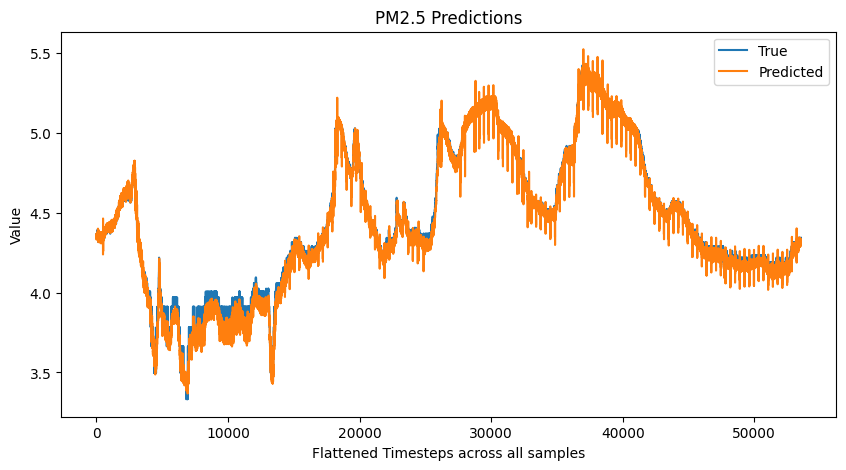

In [73]:
plot_all_predictions_flat(test_y, pred_y, feature_index=0, title="PM2.5 Predictions")

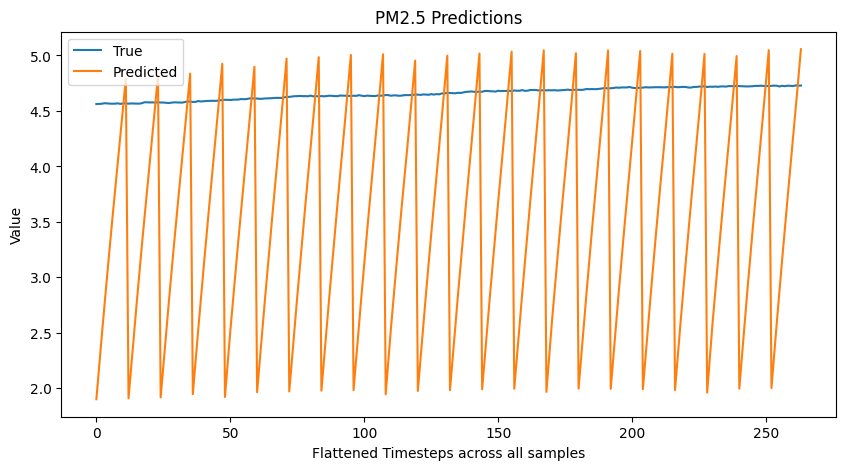

In [35]:
plot_all_predictions_flat(test_y, pred_y, feature_index=0, title="PM2.5 Predictions")

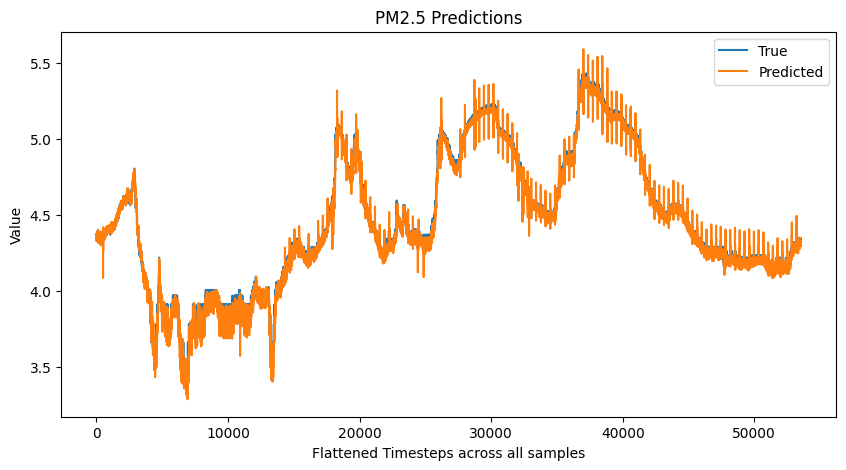

In [18]:
plot_all_predictions_flat(test_y, pred_y, feature_index=0, title="PM2.5 Predictions")

In [19]:
feature_names = ["PM2.5", "PM10", "PM1", "Temperature", "Humidity", "CO2"]

In [74]:
def plot_features_one_sample(test_y, pred_y, sample_idx=0, feature_names=None):
    # Lấy dữ liệu của sample_idx
    test_sample = test_y[sample_idx]  # shape [time_step, out]
    pred_sample = pred_y[sample_idx]  # shape [time_step, out]
    time_steps = range(test_sample.shape[0])
    
    # Nếu không truyền tên biến, tự động tạo
    if feature_names is None:
        out_dim = test_sample.shape[1]
        feature_names = [f"Feature_{i}" for i in range(out_dim)]
    
    plt.figure(figsize=(10, 5))
    # Vẽ từng feature
    for f in range(test_sample.shape[1]):
        plt.plot(time_steps, test_sample[:, f], label=f"True_{feature_names[f]}")
        plt.plot(time_steps, pred_sample[:, f], '--', label=f"Pred_{feature_names[f]}")
    
    plt.title(f"All Features")
    plt.xlabel("Time step")
    plt.ylabel("Value")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [75]:
def plot_features_multiple_samples(test_y, pred_y, sample_indices=None, feature_names=None):
    if sample_indices is None:
        sample_indices = range(test_y.shape[0])
    
    for idx in sample_indices:
        plot_features_one_sample(test_y, pred_y, sample_idx=idx, feature_names=feature_names)

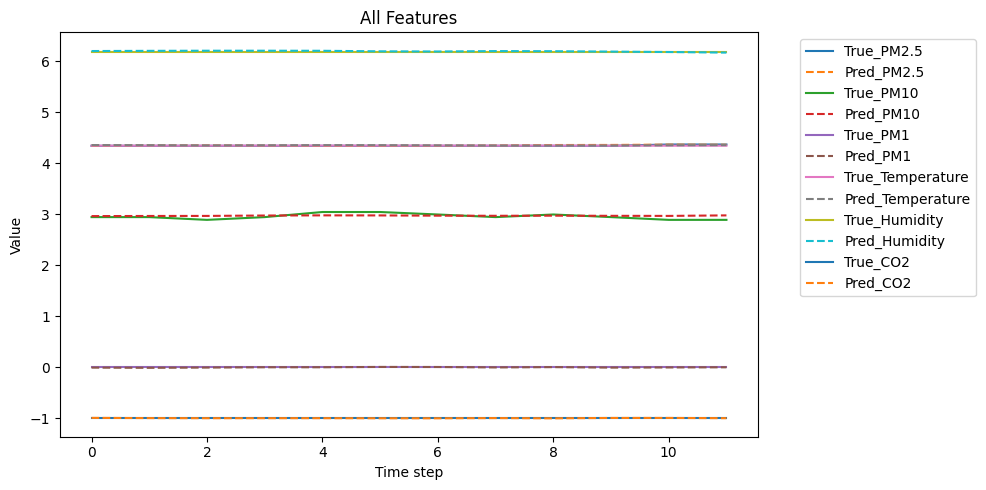

In [76]:
plot_features_multiple_samples(test_y, pred_y, sample_indices=range(1), feature_names=feature_names)

In [77]:

def plot_features_multiple_samples(test_y, pred_y, sample_indices=None, feature_names=None):
    if sample_indices is None:
        sample_indices = range(test_y.shape[0])
    if feature_names is None:
        feature_names = [f"Feature {i}" for i in range(test_y.shape[2])]

    num_features = test_y.shape[2]
    time_steps = test_y.shape[1]

    for f in range(num_features):
        plt.figure(figsize=(7, 4))
        x = np.arange(time_steps)

        for sample_idx in sample_indices:
            plt.plot(
                x, test_y[sample_idx, :, f], 
                label=f"True {feature_names[f]} (sample {sample_idx})"
            )
            plt.plot(
                x, pred_y[sample_idx, :, f], 
                linestyle='--',
                label=f"Pred {feature_names[f]} (sample {sample_idx})"
            )

        plt.title(f"{feature_names[f]}")
        plt.xlabel("Time step")
        plt.ylabel(feature_names[f])
        plt.legend()
        plt.tight_layout()
        plt.show()


In [82]:
def plot_all_predictions_flat_single_plot(test_y, pred_y, feature_names=None):
    num_samples, time_steps, num_features = test_y.shape
    
    if feature_names is None:
        feature_names = [f"Feature_{i}" for i in range(num_features)]

    plt.figure(figsize=(10, 5))

    for f in range(num_features):
        test_flat = test_y[..., f].reshape(-1)
        pred_flat = pred_y[..., f].reshape(-1)
        
        plt.plot(test_flat, label=f"True {feature_names[f]}")
        plt.plot(pred_flat, '--', label=f"Pred {feature_names[f]}")

    plt.title("All Features (Flattened) in One Plot")
    plt.xlabel("Flattened Timesteps across all samples")
    plt.ylabel("Value")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


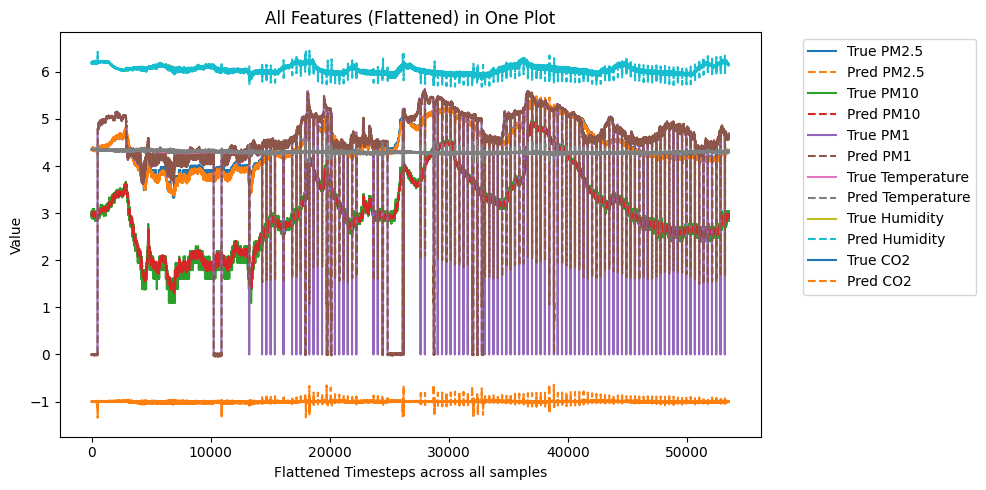

In [83]:
feature_names = ["PM2.5", "PM10", "PM1", "Temperature", "Humidity", "CO2"]
plot_all_predictions_flat_single_plot(test_y,pred_y,feature_names=feature_names)

In [1]:
def plot_all_predictions_flat_in_chunks(test_y, pred_y, feature_names=None, chunk_size=1000):

    num_samples, time_steps, num_features = test_y.shape
    
    if feature_names is None:
        feature_names = [f"Feature_{i}" for i in range(num_features)]

    test_flat = test_y.reshape(-1, num_features)
    pred_flat = pred_y.reshape(-1, num_features)
    
    total_length = test_flat.shape[0]
    
    num_chunks = (total_length + chunk_size - 1) // chunk_size  
    
    fig, axes = plt.subplots(
        num_chunks, 1,
        figsize=(10, 5 * num_chunks),
        sharex=False
    )
    
    if num_chunks == 1:
        axes = [axes]
    
    for chunk_idx in range(num_chunks):
        start_idx = chunk_idx * chunk_size
        end_idx = min(start_idx + chunk_size, total_length)
        
        ax = axes[chunk_idx]
        
        for f in range(num_features):
            ax.plot(
                range(start_idx, end_idx),
                test_flat[start_idx:end_idx, f],
                label=f"True {feature_names[f]}"
            )
            ax.plot(
                range(start_idx, end_idx),
                pred_flat[start_idx:end_idx, f],
                '--',
                label=f"Pred {feature_names[f]}"
            )
        
        ax.set_title(f"All Features (Flattened) - Chunk {chunk_idx + 1}")
        ax.set_xlabel("Flattened Timesteps across all samples")
        ax.set_ylabel("Value")
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()